In [5]:
!pip install imbalanced-learn xgboost gradio --quiet


STEP 2: Import Libraries

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import gradio as gr


STEP 3: Load Dataset

In [7]:
df = pd.read_csv('cs-training.csv', index_col=0)
df.head()


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


STEP 4: Preprocess Data (Missing Values, Basic Features)

In [8]:
# Fill missing MonthlyIncome and NumberOfDependents with median
df['MonthlyIncome'].replace(0, np.nan, inplace=True)
df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True)
df['NumberOfDependents'].fillna(df['NumberOfDependents'].median(), inplace=True)

# Target and Features
y = df['SeriousDlqin2yrs']
X = df.drop('SeriousDlqin2yrs', axis=1)

# Extra Features
X['DebtToIncomeRatio'] = X['DebtRatio'] / (X['MonthlyIncome'] + 1)
X['LatePaymentFlag'] = (X['NumberOfTime30-59DaysPastDueNotWorse'] > 0).astype(int)


<ipython-input-8-6e1adf860ebb>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['MonthlyIncome'].replace(0, np.nan, inplace=True)
<ipython-input-8-6e1adf860ebb>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

STEP 5: Balance Classes with SMOTE

In [9]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)


STEP 6: Train/Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)


STEP 7: Train Models

In [11]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:19:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

STEP 8: Evaluate

In [12]:
def print_metrics(model, X, y, name):
    y_pred = model.predict(X)
    print(f"\n{name} Results:")
    print(classification_report(y, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y, y_pred))
    print("ROC-AUC:", roc_auc_score(y, model.predict_proba(X)[:, 1]))

print_metrics(rf, X_test, y_test, "Random Forest")
print_metrics(xgb, X_test, y_test, "XGBoost")



Random Forest Results:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92     27925
           1       0.92      0.91      0.92     28065

    accuracy                           0.92     55990
   macro avg       0.92      0.92      0.92     55990
weighted avg       0.92      0.92      0.92     55990

Confusion Matrix:
[[25746  2179]
 [ 2448 25617]]
ROC-AUC: 0.9747883199268356

XGBoost Results:
              precision    recall  f1-score   support

           0       0.86      0.91      0.89     27925
           1       0.91      0.85      0.88     28065

    accuracy                           0.88     55990
   macro avg       0.88      0.88      0.88     55990
weighted avg       0.88      0.88      0.88     55990

Confusion Matrix:
[[25541  2384]
 [ 4175 23890]]
ROC-AUC: 0.9565900575161159


STEP 9: Gradio Interface for Prediction

In [13]:
feature_list = [
    'RevolvingUtilizationOfUnsecuredLines',
    'age',
    'NumberOfTime30-59DaysPastDueNotWorse',
    'DebtRatio',
    'MonthlyIncome',
    'NumberOfOpenCreditLinesAndLoans',
    'NumberOfTimes90DaysLate',
    'NumberRealEstateLoansOrLines',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfDependents'
]

def predict_default(
    RevolvingUtilizationOfUnsecuredLines, age, NumberOfTime30_59DaysPastDueNotWorse,
    DebtRatio, MonthlyIncome, NumberOfOpenCreditLinesAndLoans, NumberOfTimes90DaysLate,
    NumberRealEstateLoansOrLines, NumberOfTime60_89DaysPastDueNotWorse, NumberOfDependents
):
    # DataFrame input
    input_df = pd.DataFrame([[
        RevolvingUtilizationOfUnsecuredLines, age, NumberOfTime30_59DaysPastDueNotWorse,
        DebtRatio, MonthlyIncome, NumberOfOpenCreditLinesAndLoans, NumberOfTimes90DaysLate,
        NumberRealEstateLoansOrLines, NumberOfTime60_89DaysPastDueNotWorse, NumberOfDependents
    ]], columns=feature_list)
    # Feature Engineering
    input_df['DebtToIncomeRatio'] = input_df['DebtRatio'] / (input_df['MonthlyIncome'] + 1)
    input_df['LatePaymentFlag'] = (input_df['NumberOfTime30-59DaysPastDueNotWorse'] > 0).astype(int)
    # Predict
    prob_rf = rf.predict_proba(input_df)[0][1]
    prob_xgb = xgb.predict_proba(input_df)[0][1]
    return (
        f"{prob_rf:.2%}",
        f"{prob_xgb:.2%}",
        "Yes" if prob_rf > 0.5 else "No",
        "Yes" if prob_xgb > 0.5 else "No"
    )

iface = gr.Interface(
    fn=predict_default,
    inputs=[
        gr.Slider(0, 10, label="Revolving Utilization of Unsecured Lines"),
        gr.Slider(18, 100, label="Age"),
        gr.Slider(0, 20, label="Times 30-59 Days Past Due"),
        gr.Slider(0, 100, label="Debt Ratio"),
        gr.Slider(0, 50000, step=100, label="Monthly Income"),
        gr.Slider(0, 30, label="Open Credit Lines and Loans"),
        gr.Slider(0, 20, label="Times 90 Days Late"),
        gr.Slider(0, 10, label="Real Estate Loans or Lines"),
        gr.Slider(0, 20, label="Times 60-89 Days Past Due"),
        gr.Slider(0, 10, label="Number of Dependents"),
    ],
    outputs=[
        gr.Textbox(label="Random Forest Default Probability"),
        gr.Textbox(label="XGBoost Default Probability"),
        gr.Textbox(label="Flagged High Risk? (Random Forest)"),
        gr.Textbox(label="Flagged High Risk? (XGBoost)")
    ],
    title="Credit Default Risk Prediction"
)

iface.launch(share=True)  # Use share=True to get a public link


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d89637e7fcd2d54fd2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1. Confusion Matrix

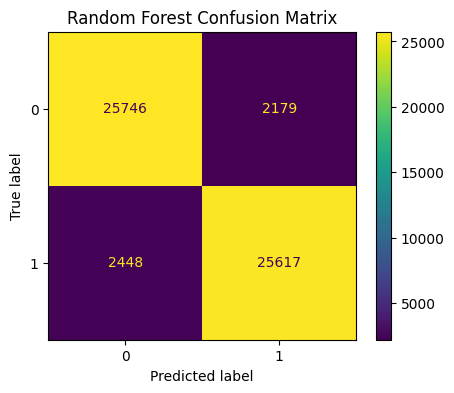

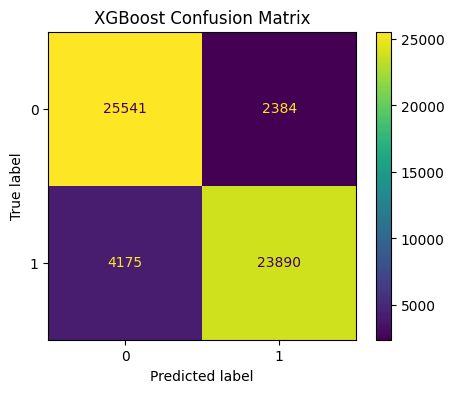

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# After predictions (use y_pred_rf and y_pred_xgb as predicted labels for test set)
y_pred_rf = rf.predict(X_test)
y_pred_xgb = xgb.predict(X_test)

fig, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, ax=ax)
plt.title('Random Forest Confusion Matrix')
plt.show()

fig, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, ax=ax)
plt.title('XGBoost Confusion Matrix')
plt.show()


2. ROC Curve

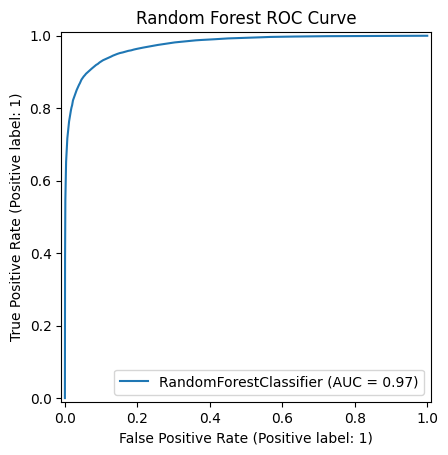

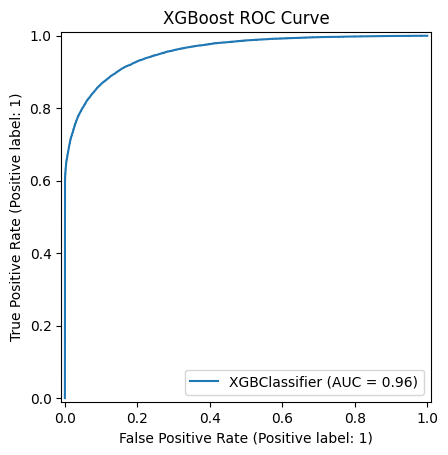

In [15]:
from sklearn.metrics import RocCurveDisplay

# Random Forest ROC Curve
RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title('Random Forest ROC Curve')
plt.show()

# XGBoost ROC Curve
RocCurveDisplay.from_estimator(xgb, X_test, y_test)
plt.title('XGBoost ROC Curve')
plt.show()


3. Feature Importance

Random Forest:

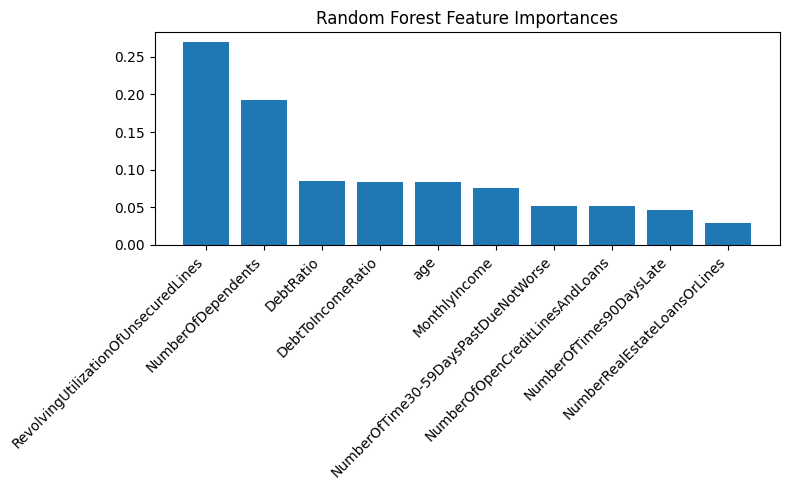

In [16]:
importances = rf.feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
plt.title("Random Forest Feature Importances")
plt.bar(range(10), importances[indices][:10])
plt.xticks(range(10), features[indices][:10], rotation=45, ha='right')
plt.tight_layout()
plt.show()


XGBoost:

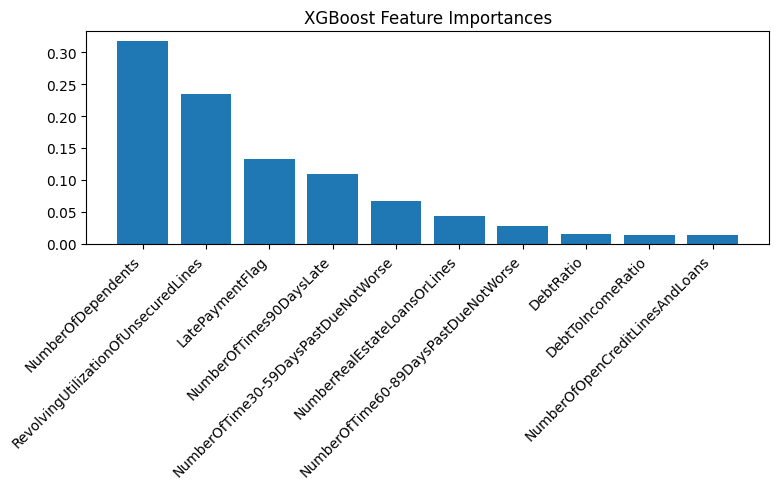

In [17]:
importances = xgb.feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
plt.title("XGBoost Feature Importances")
plt.bar(range(10), importances[indices][:10])
plt.xticks(range(10), features[indices][:10], rotation=45, ha='right')
plt.tight_layout()
plt.show()
